In [1]:
import json
import math
import numpy as np
import os
import pandas as pd
import random
import requests
import shlex
import subprocess
import sys
import time
import uuid
from pathlib import Path
from PIL import ImageFont, ImageDraw, Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display


# Setup

In [ ]:
# enter Azure credentials
SUB_KEY = "ENTER_SUBSCRIPTION_KEY"
LOCATION = "ENTER_RESOURCE_LOCATION"

In [429]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("./").expanduser() # change if putting notebook diff folder
HOME_DIR

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

FONT_DIR = HOME_DIR / Path("./fonts/")
IMAGE_DIR = HOME_DIR / data_dir / Path("./images/")

DOC_DIR = HOME_DIR / 'doc'

##  Functions

In [395]:

def translate_text_with_microsoft(text_list, sub_key, location, from_lang='en',to_lang='zh-Han'):
  """Return list of translated text using Microsoft Translator

  Find Translator trial: https://www.microsoft.com/en-us/translator/business/trial/
  Translator language codes: https://docs.microsoft.com/en-us/azure/cognitive-services/translator/language-support
  Free tier service for Microsoft Translator includes 2million characters per month

  Args:
    text_list: list of strings, text to translate
    sub_key: string, subcription key for resouce in Azure
    location: string, 
    from_lang: string, source language 
    to_lang: sring, destination language

  Returns
    trans_text: list, translated text 

  """
  endpoint = "https://api.cognitive.microsofttranslator.com"

  path = '/translate'
  constructed_url = endpoint + path

  params = {'api-version': '3.0',
            'from': from_lang,
            'to': to_lang # can do multiple languages
  }
  constructed_url = endpoint + path

  headers = {
      'Ocp-Apim-Subscription-Key': sub_key,
      'Ocp-Apim-Subscription-Region': location,
      'Content-type': 'application/json',
      'X-ClientTraceId': str(uuid.uuid4())
  }

  # can do multiple objects here
 # if len(text) ==1:
  body = [{'text': t} for t in text_list]
    #else
    #body = 

    

  request = requests.post(constructed_url, params=params, headers=headers, json=body)
  response = request.json()

   #if len(text) ==1:
    #trans_text = response[0]['translations'][0]['text']
    #else
  trans_text =  [r['translations'][0]['text'] for r in response]

  # single text trans_text = response[0]['translations'][0]['text']
  # print(json.dumps(response, sort_keys=True, ensure_ascii=False, indent=4, separators=(',', ': ')))
  return trans_text


def make_trans_df_chunk(text_list,lang_code):
  df = pd.DataFrame(text_list, columns = ["text"])
  df["language_code"] = lang_code
  df["text_code"] = list(range(0,len(text_list)))
  df["n_chars"] = list(map(lambda x: len(x), text_list))

  return df



def generate_translation_dataframe(text_list, dest_lang_codes,sub_key,location):
  """Make dataframe with translated text from list of languages

  Args:
    text_list: list of strings to translate
    dest_lang_codes: list of language codes to traslate to  (e.g. 'en', 'zh')

  Returns:
    df_trans: pd.DataFrame of translated text
  """

  #df_trans = make_trans_df_chunk(text_list,"en")
  df_trans = pd.DataFrame()

  for code in dest_lang_codes:
    trans_list = translate_text_with_microsoft(text_list, sub_key, location, from_lang='en',to_lang=code)

    df = make_trans_df_chunk(trans_list,code)


    df_trans = pd.concat([df_trans,df])

  return df_trans


# borrowed code

def img_resize_fixed_aspect(img, fixed_width=None, fixed_height=256):
    w, h = img.size
    if fixed_height:
        return img.resize((int(w * fixed_height / h), fixed_height))
    elif fixed_width:
        raise Exception("Not implemented.")


def attach_img(
    images,
    fixed_height=None,
    display_img_full_size=False,
    display_figsize=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of images (of PIL Image class or image paths), attach them horizontally and return a new image.
    
    images: list of images or a list of paths to images
    fixed_height: all images are resized (while fixing the aspect ratio) to the specified height.
    If you don't want to resize, set this to None
    display_img_full_size: If true, will display the image at full resolution
    display_figsize: if given, as (x,y), will use matplotlib to display images with figsize=(x,y)
    pixel_size_upperbound: if given, images with width or height above this number will be resized down 
    while fixing the aspect ratio until both the width and height is at most the number.
    """
    if isinstance(images[0], str) or isinstance(images[0], Path):
        images = [Image.open(str(img_path)) for img_path in images]
    if fixed_height is not None:
        images = [
            img_resize_fixed_aspect(img, fixed_height=fixed_height) for img in images
        ]
    if pixel_size_upperbound is not None:
        for i in range(len(images)):
            w, h = images[i].size
            if w > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (pixel_size_upperbound, int(pixel_size_upperbound / w * h))
                )
            w, h = images[i].size
            if h > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (int(pixel_size_upperbound / h * w), pixel_size_upperbound)
                )
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new("RGB", (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if display_img_full_size:
        display(new_im)  # This shows image at full resolution
    if display_figsize:
        fig = plt.figure(figsize=display_figsize)
        plt.imshow(
            np.asarray(new_im)
        )  # This shows scaled down version in matplotlib plot using figsize
    return (new_im, widths, heights)


# Translation

**ONLY RUN THIS SECTION FOR NEW TRANSLATION DATA SETS. CAN JUST LOAD THE TRANSLATED CSV FILE IN DATA FOLDER TO EXPLORE ANALYSIS**

In [5]:
# load dataframe with script and language info
df_lang_info = pd.read_csv(data_dir / 'languages.csv')
df_lang_info

,script_name,script_type,language,language_family,language_sub_family,language_code,font,oreintation,characters,consonants,vowels,secondary_type
0,Latin,alphabet,English,Indo-European,NaN,en,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN
1,Latin,alphabet,Spanish,Indo-European,NaN,es,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN
2,Latin,alphabet,Vietnamese,Indo-European,NaN,vi,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN
3,Latin,alphabet,Swahili,Niger-Congo,Atlantic-Congo,sw,NotoSans-Regular.ttf,NaN,NaN,NaN,NaN,NaN
4,Chinese (simplified),logographic,Chinese,Sino-tibetan,NaN,zh-Hans,NotoSansCJKsc-Regular.otf,NaN,NaN,NaN,NaN,NaN
5,Arabic,abjad,Arabic,Afro-Asiatic,Semitic,ar,NotoSansArabic-Regular.ttf,left-right,NaN,NaN,NaN,when diacrtics used abugida
6,Devanagari,abugida,Hindi,Indo-European,NaN,hi,NotoSansDevanagari-Regular.ttf,NaN,47.0,33.0,14.0,NaN
7,Bengali–Assamese,abugida,Bengali,Indo-European,NaN,bn,NotoSansBengali-Regular.ttf,NaN,NaN,NaN,NaN,NaN
8,Cyrillic,alphabet,Russian,Indo-European,Balto-Slavic,ru,NotoSans-Regular.ttf,NaN,NaN,NaN,NaN,NaN
9,Hangul,alphabet,Korean,NaN,NaN,ko,NotoSansCJKsc-Regular.otf,multiple,NaN,NaN,NaN,features


In [8]:
# Exmaple: single list translation
translate_text_with_microsoft(["lets go to the market","cat"], SUB_KEY,LOCATION, from_lang='en',to_lang='te')

['మార్కెట్ కు వెళదాం', 'పిల్లి']

In [40]:
# Example: Get dataframe of translations from List of text
text_list = ["homework","human after all"]
lang_codes = ["zh","te","ru","en"]
generate_translation_dataframe(text_list, lang_codes,SUB_KEY,LOCATION)

,text,language_code,text_code,n_chars
0,作业,zh,0,2
1,毕竟人类,zh,1,4
0,ఇంటిపని,te,0,7
1,మానవ ుల,te,1,7
0,домашнее задание,ru,0,16
1,человек в конце концов,ru,1,22
0,homework,en,0,8
1,human after all,en,1,15


In [6]:
# custom multi word phrases
phrases = ["hi how are you",
           "hello world",
           "thank you",
           "i am sorry",
           "i do not understand",
           "nice to meet you",
           "excuse me",
           "Where is the beach",
           "I am a doctor"]

## loading word list
df_1000words = pd.read_csv(data_dir / '1000words.txt')
df_4letters = df_1000words[(df_1000words.words.str.len() > 4)]
text_list_530 = list(df_4letters.words.values) + phrases
text_list_530[0:5]

['other', 'there', 'which', 'their', 'about']

In [62]:
# Make the translation dataframe from phrase list and df_lang_info
lang_codes = df_lang_info.language_code.values

# think 
df_trans = pd.DataFrame()
for chunk in np.array_split(text_list_530,10):
    df = generate_translation_dataframe(chunk, lang_codes,SUB_KEY,LOCATION)
    df_trans = pd.concat([df_trans,df])

In [63]:
df_trans

,text,language_code,text_code,n_chars
0,other,en,0,5
1,there,en,1,5
2,which,en,2,5
3,their,en,3,5
4,about,en,4,5
...,...,...,...,...
47,எனக்கு புரியவில்லை,ta,47,18
48,உங்களைச் சந்தித்ததில் மகிழ்ச்சி,ta,48,31
49,மன்னிக்கவும்,ta,49,12
50,கடற்கரை எங்கே,ta,50,13


In [8]:
df_full = pd.merge(df_trans,df_lang_info,on='language_code')
df_full.head()

NameError: name 'df_trans' is not defined

In [67]:
# explore getting more 'accurate' character counts
#w = 'ఇష్టం'
#print(len(w))
#w2 = w.replace([^\u0C05-\u0C39\u0C58-\u0C61]/g, '').length
#print(len(w2))

5


# Save/Load premade dataframe

In [423]:
# LOAD

# Dataset 1
df_full =  pd.read_csv(Path(data_dir / "translated_530.csv"))

# Dataset 2
#df_full =  pd.read_csv(Path(data_dir / "translated_530_width_matched.csv"))

# WRITE
#df_full.to_csv(data_dir / "translated_530.csv")

In [ ]:
# fix path name (dont need now)
#df_full.rename(columns={'image_path':"path"},inplace=True)

In [392]:
# fix text codes (the chunking above messed this up, don't need now)
#df_full["text_code"] = list(range(529))*12

# Make images

In [308]:
def draw_text_img(text, fontpath, save_dir = '', font_size = 32, text_loc= (35,75), can_size = (200,400,3), colors = (0,255,0,0),img_stats=False):
  ## Make canvas and set the color
  img = np.zeros(can_size,np.uint8)

  font = ImageFont.truetype(str(fontpath), font_size)

  img_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(img_pil)
  try:
    draw.text(text_loc,  text, font = font, fill = colors)
    width, height = draw.textsize(text, font=font)  
    n_pixels = np.count_nonzero(np.array(img_pil))  
  except:
    width = 0
    n_pixels = 0
    pass
  
  # to record for dataframe, maybe text size impacts what is salient.
  

  if save_dir:
    img_pil.save(str(save_dir),"jpeg")
  if img_stats:
      return img_pil, width, n_pixels
  else:
      return img_pil
# 


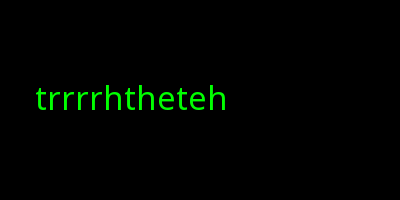

In [407]:
# Example: draw single image
font_path = Path(FONT_DIR / df_full.iloc[0].font)
img = draw_text_img(df_full.iloc[0].text,font_path)\

img



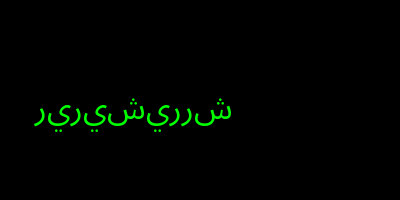

In [411]:
# Example: attched image
row = 3001
font_path = Path(FONT_DIR / df_full.iloc[row].font)
img2 = draw_text_img(df_full.iloc[row].text,font_path)
img2

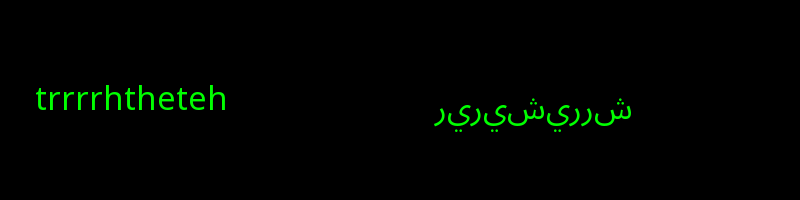

In [412]:
# Example: attached image

attach_img([img,img2])[0]

In [51]:
# MAIN CELL: Draw all images in dataframe

paths = [] 
widths = []
pixels = []
for i, row in df_full.iterrows():
  
  font_path = Path(FONT_DIR / row.font)
  image_path = Path(IMAGE_DIR / f'{row.language}_{row.text_code}.jpeg')
  paths.append(image_path)

  #img = draw_text_img(row.text,font_path,save_dir = image_path)
  img,width,n_pixels = draw_text_img(row.text,font_path,img_stats = True)
  
  widths.append(width)
  pixels.append(n_pixels)

    
df_full["path"] = paths
df_full["text_width"] = widths
df_full["text_pixels"] = pixels

other
there
which
their
about
write
would
these
thing
could
number
sound
people
water
first
place
where
after
little
round
every
under
through
sentence
great
think
differ
cause
before
right
three
small
large
spell
follow
change
light
house
picture
again
animal
point
mother
world
build
earth
father
stand
should
country
found
answer
school
study
still
learn
plant
cover
between
state
never
thought
cross
start
might
story
lizard
while
press
close
night
north
together
white
children
begin
example
paper
group
always
music
those
often
letter
until
river
second
carry
science
friend
began
mountain
horse
watch
color
enough
plain
usual
young
ready
above
though
family
direct
leave
measure
product
black
short
numeral
class
question
happen
complete
order
south
problem
piece
since
whole
space
heard
better
during
hundred
remember
early
ground
interest
reach
listen
table
travel
morning
simple
several
vowel
toward
against
pattern
center
person
money
serve
appear
govern
notice
voice
power
certain
machine

# Example of all languages

In [100]:
df_full.query("text == 'hello world'")
df_full.query("text_code == 521")

,Unnamed: 0,text,language_code,text_code,n_chars,script_name,script_type,language,language_family,language_sub_family,font,oreintation,characters,consonants,vowels,secondary_type,path,text_width,text_pixels
521,521,hello world,en,521,11,Latin,alphabet,English,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/English_44.jpeg,174,1432
1050,1050,Hola mundo,es,521,10,Latin,alphabet,Spanish,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/Spanish_44.jpeg,192,1469
1579,1579,Chào thế giới,vi,521,13,Latin,alphabet,Vietnamese,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/Vietnamese_44.jpeg,201,1774
2108,2108,Vipi dunia,sw,521,10,Latin,alphabet,Swahili,Niger-Congo,Atlantic-Congo,NotoSans-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Swahili_44.jpeg,148,1237
2637,2637,世界您好,zh-Hans,521,4,Chinese (simplified),logographic,Chinese,Sino-tibetan,NaN,NotoSansCJKsc-Regular.otf,NaN,NaN,NaN,NaN,NaN,data/images/Chinese_44.jpeg,128,1640
3166,3166,مرحبا بالعالم,ar,521,13,Arabic,abjad,Arabic,Afro-Asiatic,Semitic,NotoSansArabic-Regular.ttf,left-right,NaN,NaN,NaN,when diacrtics used abugida,data/images/Arabic_44.jpeg,222,1687
3695,3695,हैलो वर्ल्ड,hi,521,11,Devanagari,abugida,Hindi,Indo-European,NaN,NotoSansDevanagari-Regular.ttf,NaN,47.0,33.0,14.0,NaN,data/images/Hindi_44.jpeg,129,1479
4224,4224,হ্যালো ওয়ার্ল্ড,bn,521,15,Bengali–Assamese,abugida,Bengali,Indo-European,NaN,NotoSansBengali-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Bengali_44.jpeg,231,2319
4753,4753,Всем привет,ru,521,11,Cyrillic,alphabet,Russian,Indo-European,Balto-Slavic,NotoSans-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Russian_44.jpeg,204,1703
5282,5282,전 세계 여러분 안녕하세요,ko,521,14,Hangul,alphabet,Korean,NaN,NaN,NotoSansCJKsc-Regular.otf,multiple,NaN,NaN,NaN,features,data/images/Korean_44.jpeg,340,3724


In [420]:
# table for markdown
df_h = df_full.query("text_code == 500")
print(df_h.loc[:, ["text","language","script_name"]].set_index("text").to_markdown())

| text           | language   | script_name          |
|:---------------|:-----------|:---------------------|
| asiiiitnsnttia | English    | Latin                |
| etsstatsants   | Spanish    | Latin                |
| ốhhốốcccốố     | Vietnamese | Latin                |
| PhppaopPa      | Swahili    | Latin                |
| 瞬瞬间间瞬瞬   | Chinese    | Chinese (simplified) |
| هاراللهرهالور  | Arabic     | Arabic               |
| ण्णकण्षष््षष्       | Hindi      | Devanagari           |
| ্কষ্কাষতকত       | Bengali    | Bengali–Assamese     |
| еовввеоннв     | Russian    | Cyrillic             |
| 간순순간순순간 | Korean     | Hangul               |
| ాటట్ెపపుటట        | Telugu     | Telugu               |
| ொொடநந          | Tamil      | Tamil (Brahmic)      |


In [378]:
# table for markdown
df_h = df_full.query("text_code == 521")
print(df_h.loc[:, ["text","language","script_name"]].set_index("text").to_markdown())

| text                      | language   | script_name          |
|:--------------------------|:-----------|:---------------------|
| hello world               | English    | Latin                |
| Hola mundo                | Spanish    | Latin                |
| Chào thế giới             | Vietnamese | Latin                |
| Vipi dunia                | Swahili    | Latin                |
| 世界您好                  | Chinese    | Chinese (simplified) |
| مرحبا بالعالم             | Arabic     | Arabic               |
| हैलो वर्ल्ड                  | Hindi      | Devanagari           |
| হ্যালো ওয়ার্ল্ড              | Bengali    | Bengali–Assamese     |
| Всем привет               | Russian    | Cyrillic             |
| 전 세계 여러분 안녕하세요 | Korean     | Hangul               |
| హలో వరల్డ్                   | Telugu     | Telugu               |
| ஹலோ உலகம்                  | Tamil      | Tamil (Brahmic)      |


When I reverse translate from the microsoft to google for the korean phrase `전 세계 여러분 안녕하세요` translates to `hello all over the world`

# Explore size of text on images

In [53]:
import seaborn as sns

In [67]:
sns.set_context('talk')
sns.set_style('whitegrid')

NOTE: very strong correlation between width of text and number of pixels, no suprise. This means probably only need one of these measures if going to model.

<AxesSubplot:xlabel='text_width', ylabel='text_pixels'>

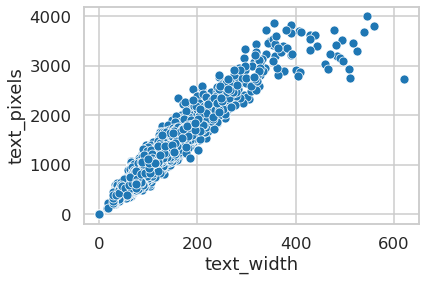

In [68]:
sns.scatterplot(data=df_full,x="text_width",y="text_pixels")

<AxesSubplot:xlabel='text_width', ylabel='n_chars'>

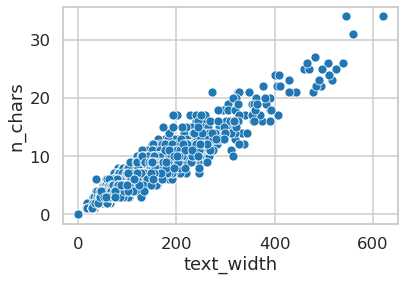

In [81]:
sns.scatterplot(data=df_full,x="text_width",y="n_chars")

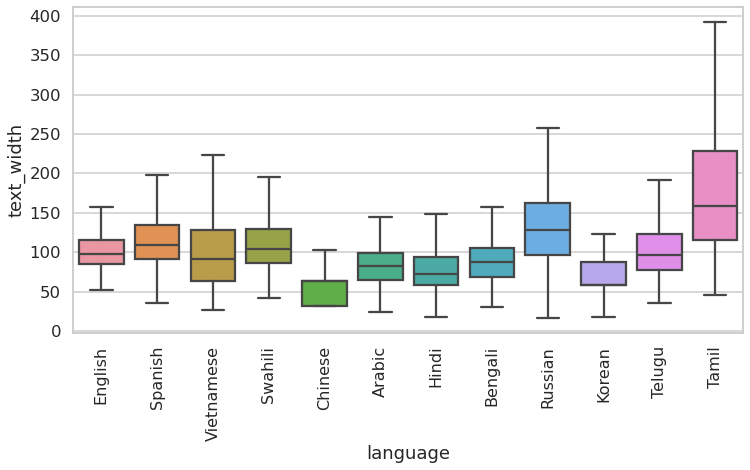

In [430]:
fig, ax = plt.subplots(1,figsize=(12,6))
sns.boxplot(ax=ax,  data=df_full,x="language",y="text_width",showfliers=False)

plt.xticks(rotation=90, fontsize=16)

plt.savefig(DOC_DIR / f"text_width_base.jpeg", bbox_inches = "tight")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'English'),
  Text(1, 0, 'Spanish'),
  Text(2, 0, 'Vietnamese'),
  Text(3, 0, 'Swahili'),
  Text(4, 0, 'Chinese'),
  Text(5, 0, 'Arabic'),
  Text(6, 0, 'Hindi'),
  Text(7, 0, 'Bengali'),
  Text(8, 0, 'Russian'),
  Text(9, 0, 'Korean'),
  Text(10, 0, 'Telugu'),
  Text(11, 0, 'Tamil')])

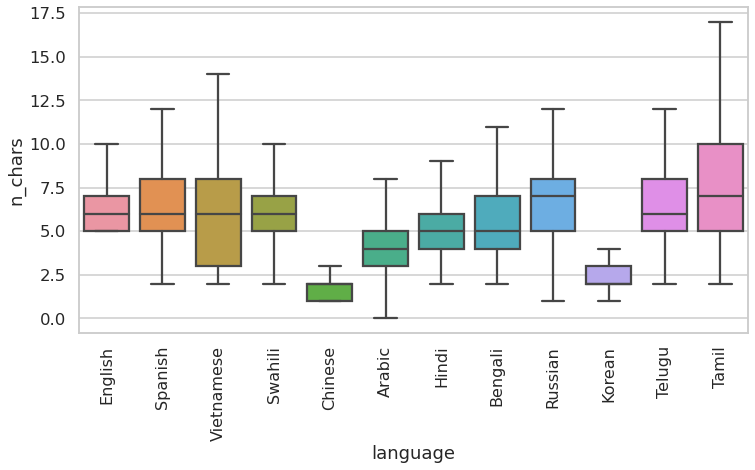

In [428]:
fig, ax = plt.subplots(1,figsize=(12,6))
sns.boxplot(ax=ax,  data=df_full,x="language",y="n_chars",showfliers=False)

plt.xticks(rotation=90, fontsize=16)

NOTE

+ Latins scripts have similar number of pixels per word, on average. But there are potentiallys significant differences, with spanish and english higher than vietnamese and swahili.
+ Chinese and arabic are amongst the smallest, and they consistent perform worse against most other languages on the saliency model. Korean is also small tho, but is preferred to all other latin scripts 

+ TODO
+ make group pairings with matched pixel sizes. But this does not address the real life scenario, where the same words in two different languages have differnt sizes (i.e. character length, text 


+ why are Tamil translation so long? See: (https://www.quora.com/Why-are-Tamil-words-so-long) Others have also wondered, one speculation is the number of letters (247), also the way 

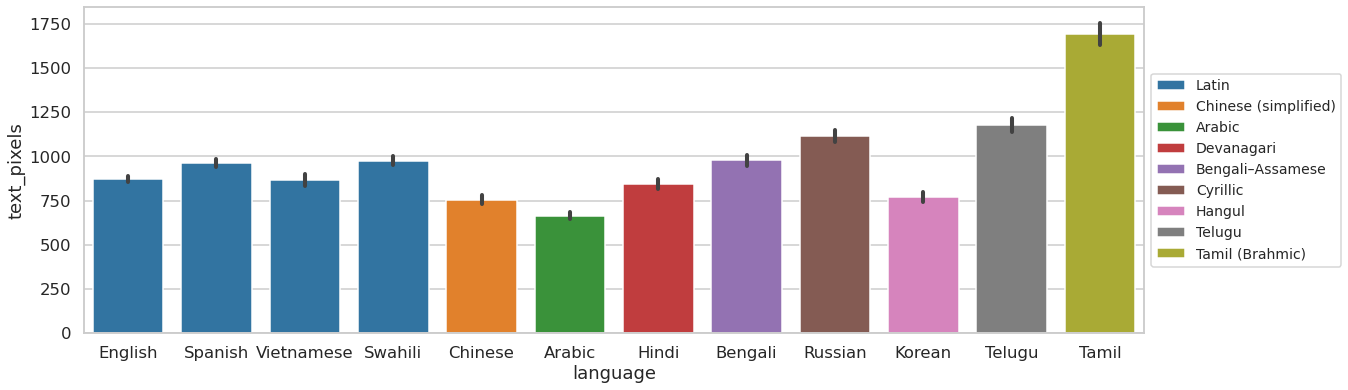

In [80]:
fig, ax = plt.subplots(1,figsize=(19,6))
sns.barplot(ax=ax, data=df_full,x="language",y="text_pixels",hue='script_name',dodge=False)
plt.legend(fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

# Sample words within similar pixel size range (maybe implement)

In [ ]:
# TODOD

# Nonsense words - even matched character (not analyzed)

In [155]:
def jumble_text(text,n_chars=7):
    """Scramble word, return with length n_chars"""

    try:
        word_ind = np.random.choice(list(range(len(text))),n_chars)
        return ''.join([text[x] for x in word_ind])
    except:
        print("Not a string")
        pass

In [161]:
df_scrambled = df_full.copy()
df_scrambled["text"] = df_scrambled.text.apply(lambda x: jumble_text(x))
df_scrambled["n_chars"] = 5
df_scrambled

Not a string
Not a string
Not a string
Not a string


,text,language_code,text_code,n_chars,script_name,script_type,language,language_family,language_sub_family,font,oreintation,characters,consonants,vowels,secondary_type,path,text_width,text_pixels
0,hettoeh,en,0,5,Latin,alphabet,English,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/English_0.jpeg,86,693
1,ehrrter,en,1,5,Latin,alphabet,English,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/English_1.jpeg,85,697
2,hhiihii,en,2,5,Latin,alphabet,English,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/English_2.jpeg,90,762
3,rreehre,en,3,5,Latin,alphabet,English,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/English_3.jpeg,73,589
4,auoabbo,en,4,5,Latin,alphabet,English,Indo-European,NaN,NotoSans-Regular.ttf,left-right,NaN,NaN,NaN,NaN,data/images/English_4.jpeg,91,782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,ிலிலகரல,ta,524,5,Tamil (Brahmic),abugida,Tamil,Dravidian,Southern,NotoSansTamil-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Tamil_47.jpeg,392,3238
6344,்தசமைிஉ,ta,525,5,Tamil (Brahmic),abugida,Tamil,Dravidian,Southern,NotoSansTamil-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Tamil_48.jpeg,560,3801
6345,னனிக்னக,ta,526,5,Tamil (Brahmic),abugida,Tamil,Dravidian,Southern,NotoSansTamil-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Tamil_49.jpeg,249,2344
6346,்ங்ேக்எ,ta,527,5,Tamil (Brahmic),abugida,Tamil,Dravidian,Southern,NotoSansTamil-Regular.ttf,NaN,NaN,NaN,NaN,NaN,data/images/Tamil_50.jpeg,281,2609


In [ ]:
Path(FONT_DIR / row.font)

width,n_pixels = draw_text_img(row.text,Path(FONT_DIR / row.font),img_stats = True)

In [170]:
# Draw all images in dataframe

paths = [] 
widths = []
pixels = []
for i, row in df_scrambled.iterrows():
  
  font_path = Path(FONT_DIR / row.font)
  image_path = Path(str(IMAGE_DIR) + '_scrambled_7char') / f'{row.language}_{row.text_code}.jpeg'
  paths.append(image_path)

  #img = draw_text_img(row.text,font_path,save_dir = image_path)
  img,width,n_pixels = draw_text_img(row.text,font_path,img_stats = True) # A
  
  widths.append(width)
  pixels.append(n_pixels)

    
df_scrambled["path"] = paths
df_scrambled["text_width"] = widths
df_scrambled["text_pixels"] = pixels

hettoeh
ehrrter
hhiihii
rreehre
auoabbo
wttrier
oulolwu
teseehs
ngttihn
dlddccl
neuerem
sdusuou
lepeplo
wwataet
riiffif
aapaece
hrreeee
attrrtr
iiltltt
unoodnn
ryveerv
nreerun
uhuhroo
ntecees
rtegtgg
tkhntki
ffffffe
ssasacu
froreor
ihgtith
errheth
samlsms
rlleerr
pplplle
ffowllo
agccnag
giilith
esehehh
ueucttc
innaaia
lmmaali
piotiot
hhmrtrm
ldrrolo
bliiiii
tearrae
fhefeha
dtdsttn
ddsoshl
uyuyuyo
fodnoon
aesreaa
hsslohs
ydtsssu
silisli
aeneenr
ptanpnn
ovevcoe
eewette
asatets
rnevrvr
ohhtthh
rsssrso
ttrrtsa
tihmggt
ottotss
dlraiar
eweelwi
serprre
ccseccl
gtghnng
hotohot
tehetre
thtwhti
clchnec
bgeggni
mlpalxx
reepapp
oopuggo
llayawa
ssccuim
soehsos
otetfnn
etlltrt
niulnti
rrvrrvr
eodsond
cayyrac
innecns
ddndefe
naeeabe
ummtiot
ehreeos
ctacaha
ocoocoo
ugneohe
paanpll
aaauuuu
nggnugn
ddyyery
bvoaaav
uguuoho
lialllm
deeddrd
elevave
ueeesmm
rtcrduu
lckabal
tstooso
nunullm
cscsssl
eetutsq
papphpp
ptppete
doeoerr
ssshtth
pmoelob
eiieeii
ncsnnsn
wlehewo
epcpsas
redrerh
etetebt
diunnri
hdnnuhh


# Make nonsense words: width matched

In [311]:
def jumble_text_match_text_width(df):
    """Draw the word, one random character at a time, until the width is at least 200"""
    
    
    for i, row in df.iterrows():
        word = ''
        word_width = 0
        try:
            while (word_width < 175):
                word_ind = np.random.choice(list(range(len(row.text))),1)[0]
                word = word + row.text[word_ind]
                _,word_width,_ = draw_text_img(word,Path(FONT_DIR / row.font),img_stats = True)
            
            df.loc[i,"text"] = word

        except:
            print("Not a string")
            pass
    return df

def draw_images_from_dataframe(df,img_dir=''):
    paths = [] 
    widths = []
    pixels = []
    for i, row in df.iterrows():

      font_path = Path(FONT_DIR / row.font)
      image_path = img_dir / f'{row.language}_{row.text_code}.jpeg'
      paths.append(image_path)

      #img = draw_text_img(row.text,font_path,save_dir = image_path)
      img,width,n_pixels = draw_text_img(row.text,font_path,save_dir=image_path, img_stats = True)

      widths.append(width)
      pixels.append(n_pixels)


    df["path"] = paths
    df["text_width"] = widths
    df["text_pixels"] = pixels
    
    return df

In [314]:
# NEW DATAFRAME FOR WIDTH MATCHED
df_width_matched = jumble_text_match_text_width(df_full.copy())

Not a string
Not a string
Not a string
Not a string


In [342]:
# Draw all images in dataframe
df_alt = draw_images_from_dataframe(df_width_matched.copy(), Path(str(IMAGE_DIR) + '_width_matched'))

In [364]:
# df_alt.to_csv(data_dir / 'translated_530_width_matched.csv')

# PLOTS

<AxesSubplot:xlabel='language', ylabel='text_pixels'>

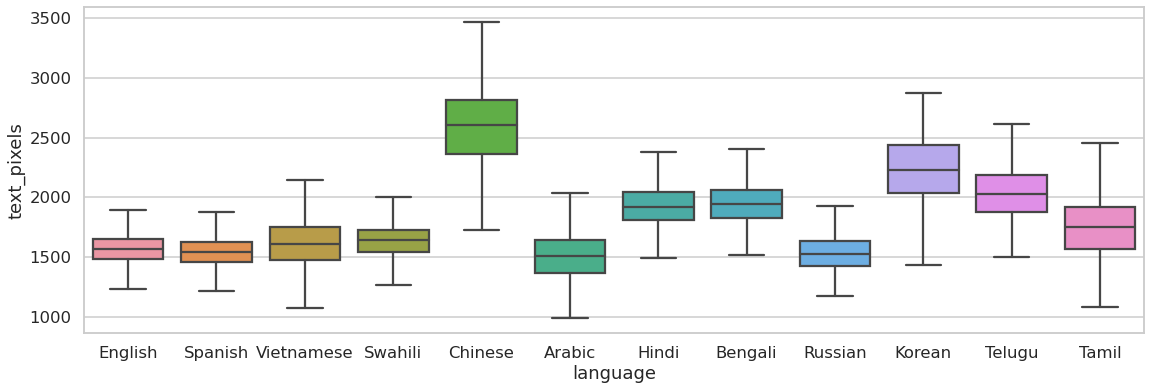

In [363]:
fig, ax = plt.subplots(1,figsize=(19,6))
sns.boxplot(ax=ax,  data=df_alt,x="language",y="text_pixels",showfliers=False)

<AxesSubplot:xlabel='language', ylabel='text_width'>

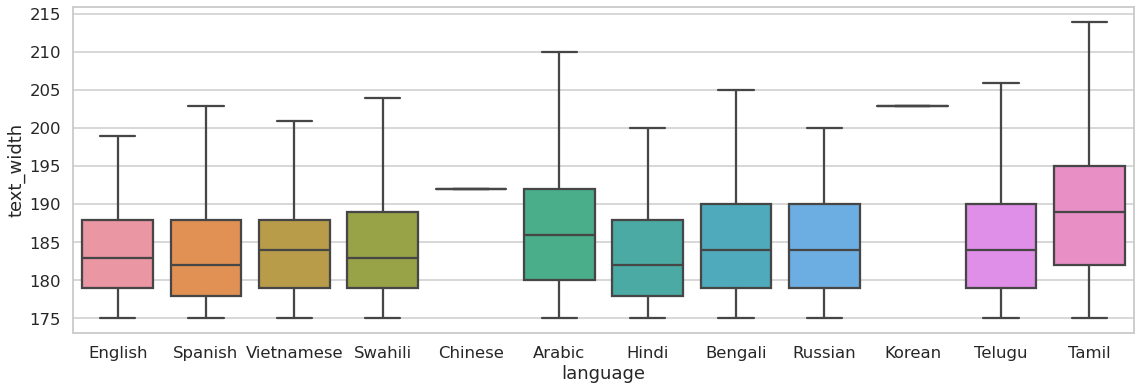

In [353]:
df_alt.to_csvfig, ax = plt.subplots(1,figsize=(19,6))
sns.boxplot(ax=ax,  data=df_alt,x="language",y="text_width",showfliers=False)

NOTE: Looks like korean and chinese are still much higher on the text_width parameter. Seems like when typing those characters, they fall into discrete bins. My must be on a threshol where the next highest bin was chosen. Nevertheless, the distributions are much tighter than the original dataset, so probably less of an impact and the gaze model.

In [360]:
df_alt.query("language_code=='ko'").loc[:,["text","language","text_width","text_pixels"]]

,text,language,text_width,text_pixels
4761,다다른다른른다,Korean,203,2082
4762,기거기거거기기,Korean,203,1792
4763,어어느느어느어,Korean,203,1828
4764,들의그그의들들,Korean,203,2272
4765,약약약약약약약,Korean,203,2107
...,...,...,...,...
5285,못하해 못하이,Korean,181,1964
5286,반나만 만반 서,Korean,188,1814
5287,실합합다합실례,Korean,203,2533
5288,니습니있은 까,Korean,195,1856


In [362]:
df_alt.query("language_code=='ru'").loc[:,["text","language","text_width","text_pixels"]]

,text,language,text_width,text_pixels
4232,гдйдгугойо,Russian,178,1617
4233,тамамаммм,Russian,195,1714
4234,тырытрокы,Russian,187,1456
4235,иххххххиии,Russian,186,1586
4236,ооолооооо,Russian,179,1498
...,...,...,...,...
4756,оа мЯаема,Russian,179,1514
4757,сменияспО,Russian,190,1475
4758,рииПтриттс,Russian,190,1465
4759,Г осяоедеяя,Russian,192,1617
